In [1]:
from nilearn import datasets
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn import plotting
import os
import glob
from joblib import Parallel, delayed
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
from nilearn.maskers import NiftiLabelsMasker, MultiNiftiLabelsMasker
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Atlas

In [3]:
from nilearn import datasets
# Note: Craddok 2012 atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, 
                                         yeo_networks=7, 
                                         resolution_mm=1, 
                                         data_dir=None, 
                                         base_url=None, 
                                         resume=True, 
                                         verbose=1)

In [4]:
import nibabel as nib
nii = nib.load('/data/gpfs-1/users/dellorca_c/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz')
nii_arr = nii.get_fdata()

In [5]:
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

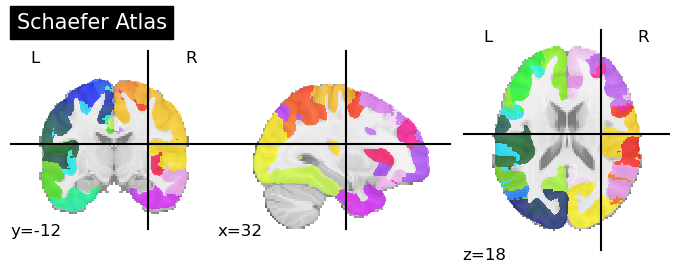

In [6]:
plotting.plot_roi(atlas_filename, title="Schaefer Atlas")
plotting.show()

# Connectivity Matrices

In [10]:
cache_dir = './nilearn_cache'

In [ ]:
%%time
bolds = glob.glob('/data/gpfs-1/users/dellorca_c/scratch/NeuroMET_fmri/*/ses-0*/func/*_ses-*_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
bolds = [i for i in bolds if not 'NeuroMET074' in i]
sids = [i.split('/')[-4] for i in bolds]
ses = [i.split('/')[-3] for i in bolds]
correlation_measure = ConnectivityMeasure(kind='correlation')
masker = MultiNiftiLabelsMasker(atlas_filename, 
                         memory=os.path.join(cache_dir, 'schaefer_atlas'), 
                         standardize='zscore_sample',
                        smoothing_fwhm=6,
                         low_pass=0.1,
                         high_pass=0.008,
                         t_r=2.2,
                        memory_level=5)
confounds_simples, sample_masks = load_confounds(
            bolds, 
            strategy=['motion', 'compcor', 'scrub', 'global_signal', 'high_pass'],
            motion = 'full', global_signal='full', 
            scrub=0, compcor='anat_separated', n_compcor=5,
            ica_aroma='basic')
bolds_tmp = bolds
time_series_list = masker.fit_transform(bolds_tmp, confounds=confounds_simples)
cor_mat_tmp = correlation_measure.fit_transform(time_series_list)
#correlation_matrices.append(cor_mat_tmp)
np.savez('./matrices_ses-all_schaefer2018.npz', mats = cor_mat_tmp, sids = sids, ses=ses)
del(time_series_list)
for n,i in enumerate(cor_mat_tmp):
    print(sids[n])
    plotting.plot_matrix(i.squeeze())
    plotting.show()

# Networks' average functional Connectivity

## grab labels' indices for each network

In [7]:
import re
labelsd = np.char.decode(labels)
nets = set([re.search(r'7Networks_[LR]H_([^_]*)_.*',i.decode()).group(1) for i in labels])
nets

{'Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis'}

In [8]:
net_dict = dict()
for i in nets:
    net_dict[i] = []

In [9]:
for n,i in enumerate(labelsd):
    for net in nets:
        if net in i:
            net_dict[net].append(n)

In [10]:
len(cor_mat_tmp)

NameError: name 'cor_mat_tmp' is not defined

## functional connectivity averages

In [95]:
conns = []
for n,mat in enumerate(cor_mat_tmp):
    conn_dict = dict()
    conn_dict['sids'] = sids[n]
    conn_dict['ses'] = ses[n]
    for i in nets:
        #print(net_dict[i])
        submat = mat[net_dict[i],:][:,net_dict[i]]
        submat_tril = np.tril(submat, k=-1)
        #submat_tril_thr = np.where(submat_tril <0, 0, submat_tril)
        submat_tril[np.triu_indices(submat_tril.shape[0],0)] = np.nan
        submat_tril_thr = np.where(submat_tril <0, 0, submat_tril)
        conn_dict[i] = np.nanmean(submat_tril_thr[submat_tril_thr>0])
    
    conns.append(conn_dict)
    

In [98]:
pd.DataFrame(conns)

,sids,ses,Vis,Cont,Default,SalVentAttn,DorsAttn,SomMot,Limbic
0,sub-NeuroMET076,ses-03,0.349223,0.375439,0.367564,0.310637,0.341602,0.313377,0.515120
1,sub-NeuroMET076,ses-02,0.306492,0.314010,0.303364,0.363526,0.336206,0.317092,0.287093
2,sub-NeuroMET076,ses-01,0.331021,0.303142,0.334278,0.418112,0.308567,0.312876,0.356530
3,sub-NeuroMET089,ses-01,0.322306,0.277398,0.319158,0.335003,0.361267,0.279265,0.348560
4,sub-NeuroMET011,ses-03,0.285847,0.290187,0.316205,0.437286,0.300122,0.433378,0.331919
...,...,...,...,...,...,...,...,...,...
199,sub-NeuroMET099,ses-01,0.288758,0.269528,0.362770,0.400757,0.327200,0.386814,0.303972
200,sub-NeuroMET028,ses-01,0.301023,0.285327,0.298679,0.286244,0.283625,0.281879,0.311286
201,sub-NeuroMET031,ses-01,0.357391,0.260799,0.259134,0.281748,0.299179,0.299206,0.304274
202,sub-NeuroMET096,ses-02,0.387319,0.344351,0.347896,0.351903,0.365298,0.414049,0.180061


In [99]:
pd.DataFrame(conns).to_csv('conns.csv', sep=';', index=False)